## Sentiment Analysis of Book Reviews: Gaining Insights into Reader Preference

**Introduction**

*This project focuses on sentiment analysis using machine learning techniques to classify text data into different sentiment categories: negative, neutral, and positive. Various models, including individual classifiers like Naye bayes, LSTM, Logistic Regression and SVM, as well as ensemble methods such as Voting and Stacking, are explored. The goal is to evaluate and compare the effectiveness of these models in accurately predicting sentiment based on text data, with performance metrics such as accuracy, classification reports, and ROC curves used for evaluation.*


# Text Data Preprocessing Pipeline

**Importing Libraries**

*Various libraries are imported for data processing (pandas, numpy), visualization (matplotlib, seaborn), machine learning (scikit-learn), and deep learning (tensorflow). These include tools for text vectorization, model training, and evaluation, along with natural language processing (nltk) and ensemble methods.*


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import nltk
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder


*These commands download the WordNet and Open Multilingual Wordnet (OMW) corpora from NLTK, which are essential for lemmatization and other natural language processing tasks.*




In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

**Loading the Dataset**

*The dataset is loaded from the specified CSV file using pandas' `read_csv` function. The first few rows of the dataset are then displayed to provide an overview of the data structure.*




In [ ]:
file_path = '/content/goodreads_top100_from1980to2023_final.csv'
df = pd.read_csv(file_path)
print("Dataset loaded successfully. Here's a preview:")
print(df.head())


Dataset loaded successfully. Here's a preview:
   Unnamed: 0         isbn                           title  \
0           0  9.78069E+12                   Summer Story    
1           1  9.78038E+12            The Lake of Darkness   
2           2  9.78035E+12  Beyond the Blue Event Horizon    
3           3  9.78045E+12               St. Peter's Fair    
4           4  9.78043E+12                       Twice Shy   

                    series_title series_release_number        authors  \
0                  Brambly Hedge                     2   Jill Barklem   
1                            NaN                   NaN   Ruth Rendell   
2                   Heechee Saga                     2  Frederik Pohl   
3  Chronicles of Brother Cadfael                     4   Ellis Peters   
4                            NaN                   NaN   Dick Francis   

                    publisher language  \
0                    Atheneum  English   
1  Vintage Crime/Black Lizard  English   
2            Ba

**Handling Missing Values**

*This function checks for missing values in the dataset and prints the count of missing values in each column. It then drops rows with missing descriptions to ensure that the data used for analysis is complete.*


In [ ]:
def handle_missing_values(df):
    print("Checking for missing values...")
    print(df.isnull().sum())

    df = df.dropna(subset=['description'])
    return df

df = handle_missing_values(df)

Checking for missing values...
Unnamed: 0                  0
isbn                      594
title                       0
series_title             2132
series_release_number    2144
authors                     0
publisher                 116
language                   26
description                 2
num_pages                  21
format                     35
genres                      0
publication_date            1
rating_score                0
num_ratings                 0
num_reviews                 0
current_readers           104
want_to_read               39
price                     233
url                         0
dtype: int64


*This code defines a function that maps the book ratings to sentiment labels. Ratings 4 and above are labeled as 'positive', ratings between 2 and 4 are labeled as 'neutral', and ratings below 2 are labeled as 'negative'. The sentiment labels are then applied to a new column in the dataset.*


In [ ]:
print("Converting ratings to sentiment labels...")
def map_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating >= 2:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['rating_score'].apply(map_sentiment)

Converting ratings to sentiment labels...




*The `clean_text` function removes non-alphabetic characters and converts the text to lowercase. Stop words are then removed using the built-in list from scikit-learn. Afterward, the text is lemmatized using NLTK's WordNetLemmatizer to reduce words to their base form. Finally, the sentiment distribution is visualized using a count plot, showing the distribution of 'positive', 'neutral', and 'negative' sentiments in the dataset.*


Cleaning text data...
Visualizing sentiment distribution...


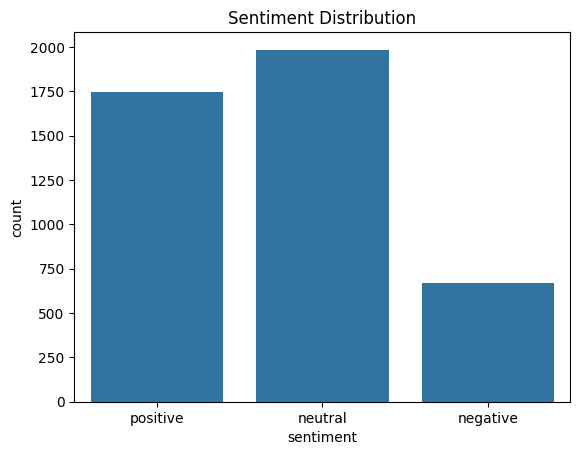

In [ ]:
print("Cleaning text data...")
def clean_text(text):
    import re
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

df['cleaned_review'] = df['description'].apply(clean_text)
df['cleaned_review'] = df['cleaned_review'].apply(lambda x: ' '.join([word for word in x.split() if word not in ENGLISH_STOP_WORDS]))

lemmatizer = WordNetLemmatizer()
df['cleaned_review'] = df['cleaned_review'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

print("Visualizing sentiment distribution...")
sns.countplot(data=df, x='sentiment')
plt.title("Sentiment Distribution")
plt.show()

**Handling Class Imbalance Using Oversampling**

*The sentiment distribution is checked, and if the class distribution is imbalanced (i.e., the ratio between the smallest and largest class is less than 0.5), Random Oversampling is applied using the `RandomOverSampler` from the imbalanced-learn library to balance the dataset. After resampling, the balanced sentiment distribution is visualized with a count plot.*


Sentiment distribution:
 sentiment
neutral     1984
positive    1744
negative     670
Name: count, dtype: int64
Handling class imbalance using oversampling...
Visualizing balanced sentiment distribution...


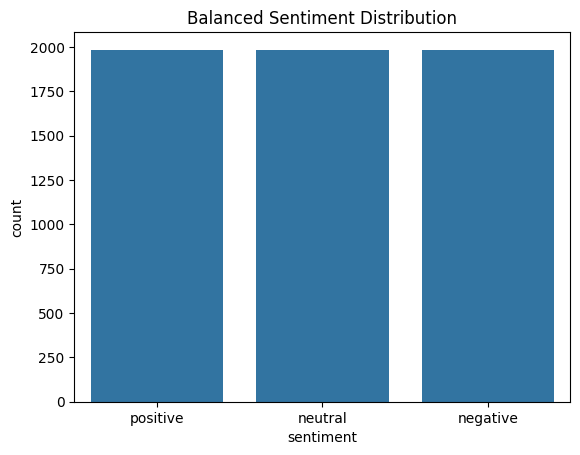

In [ ]:
sentiment_counts = df['sentiment'].value_counts()
print("Sentiment distribution:\n", sentiment_counts)
if sentiment_counts.min() / sentiment_counts.max() < 0.5:
    print("Handling class imbalance using oversampling...")
    from imblearn.over_sampling import RandomOverSampler
    ros = RandomOverSampler()
    X, y = df['cleaned_review'], df['sentiment']
    X_res, y_res = ros.fit_resample(X.values.reshape(-1, 1), y)
    df_resampled = pd.DataFrame({'cleaned_review': X_res.flatten(), 'sentiment': y_res})

    print("Visualizing balanced sentiment distribution...")
    sns.countplot(data=df_resampled, x='sentiment')
    plt.title("Balanced Sentiment Distribution")
    plt.show()
else:
    df_resampled = df

**Extracting Features Using TF-IDF**

*TF-IDF (Term Frequency-Inverse Document Frequency) is used to convert the cleaned text data into numerical features. The `TfidfVectorizer` is applied with a maximum of 10,000 features and a n-gram range of (1, 2) to capture both unigrams and bigrams. The sentiment labels are then converted into one-hot encoded format using `pd.get_dummies` to prepare for model training.*


In [ ]:
print("Extracting features using TF-IDF...")
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = tfidf.fit_transform(df_resampled['cleaned_review'])
y = df_resampled['sentiment']

y = pd.get_dummies(y).values


Extracting features using TF-IDF...


**Splitting Data into Training and Testing Sets**

*The dataset is split into training and testing sets using `train_test_split`. 80% of the data is used for training and 20% for testing, with a fixed random seed for reproducibility. This ensures the models are evaluated on unseen data for a fair performance assessment.*


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Naive Bayes Model

**Training Naive Bayes Model with Hyperparameter Tuning**

*The Naive Bayes model is trained using hyperparameter tuning with `GridSearchCV`. A grid of possible values for the smoothing parameter `alpha` is defined, and 5-fold cross-validation is used to find the best performing parameter. The best model is selected based on the highest cross-validation score and is stored for future use.*


In [ ]:
print("Training Naive Bayes model with hyperparameter tuning...")
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid.fit(X_train, y_train.argmax(axis=1))

print(f"Best parameters: {grid.best_params_}")
nb = grid.best_estimator_

Training Naive Bayes model with hyperparameter tuning...
Best parameters: {'alpha': 0.1}


**Evaluating Naive Bayes Model**

*The performance of the tuned Naive Bayes model is evaluated on the test set. The accuracy is calculated, and a classification report along with a confusion matrix are generated to provide a comprehensive evaluation of the model's performance across different sentiment classes.*


In [ ]:
print("Evaluating Naive Bayes model...")
nb_preds = nb.predict(X_test)
nb_accuracy = accuracy_score(y_test.argmax(axis=1), nb_preds)
print(f"Naive Bayes Accuracy after tuning: {nb_accuracy}")
print(classification_report(y_test.argmax(axis=1), nb_preds))
print(confusion_matrix(y_test.argmax(axis=1), nb_preds))

Evaluating Naive Bayes model...
Naive Bayes Accuracy after tuning: 0.7069689336691856
              precision    recall  f1-score   support

           0       0.90      0.72      0.80       402
           1       0.62      0.70      0.66       394
           2       0.65      0.70      0.67       395

    accuracy                           0.71      1191
   macro avg       0.72      0.71      0.71      1191
weighted avg       0.73      0.71      0.71      1191

[[291  67  44]
 [ 13 276 105]
 [ 18 102 275]]


# LSTM - Long Short-Term Memory

**Training LSTM Model**

*This code trains an LSTM model for sentiment classification on the dataset. The text data is tokenized and padded to a fixed length of 100, and the dataset is split into training and test sets. The LSTM model consists of two LSTM layers, with the first layer returning sequences and a dropout layer for regularization. The model is compiled with the Adam optimizer and categorical cross-entropy loss function. It is trained for 10 epochs with a batch size of 32, and the validation data is also provided to evaluate performance during training.*


In [ ]:
print("Training LSTM model...")
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_resampled['cleaned_review'])
X_seq = tokenizer.texts_to_sequences(df_resampled['cleaned_review'])
X_padded = pad_sequences(X_seq, maxlen=100)

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Training LSTM model...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4173 - loss: 1.0531 - val_accuracy: 0.6020 - val_loss: 0.8215
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7480 - loss: 0.5851 - val_accuracy: 0.6709 - val_loss: 0.7388
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9089 - loss: 0.2615 - val_accuracy: 0.7204 - val_loss: 0.7996
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9708 - loss: 0.0949 - val_accuracy: 0.7322 - val_loss: 0.9014
Epoch 5/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9826 - loss: 0.0631 - val_accuracy: 0.7288 - val_loss: 1.0802
Epoch 6/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9923 - loss: 0.0348 - val_accuracy: 0.7221 - val_loss: 1.1808
Epoch 7/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9942 - loss: 0.0221 - val_accuracy: 0.7170 - val_loss: 1.4668
Epoch 8/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9927 - loss: 0.0195 - val_accuracy: 0.703

**Visualizing Model Training and Validation Accuracy**

*The training and validation accuracy are plotted over epochs to visualize the model's performance during training. This helps to identify whether the model is overfitting or underfitting by comparing the training accuracy with the validation accuracy across epochs.*


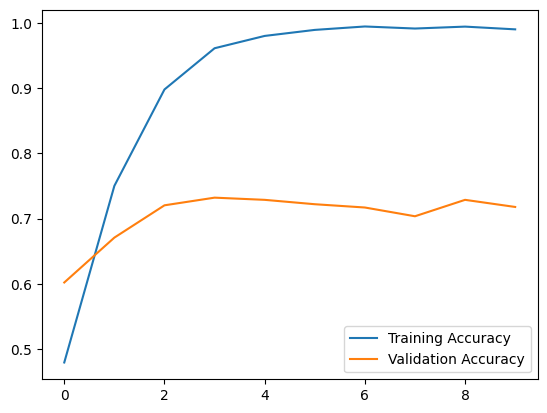

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


**Evaluating LSTM Model Performance**

*After training the LSTM model, this code evaluates its performance on the test set. The predictions are made using the model, and the accuracy is computed by comparing the predicted labels with the true labels. A classification report is also generated, providing detailed metrics such as precision, recall, and F1-score for each class, helping to assess the model's effectiveness in sentiment classification.*


In [ ]:
print("Evaluating LSTM model...")
lstm_preds = model.predict(X_test)
lstm_accuracy = accuracy_score(y_test.argmax(axis=1), lstm_preds.argmax(axis=1))
print(f"LSTM Model Accuracy: {lstm_accuracy}")
print(classification_report(y_test.argmax(axis=1), lstm_preds.argmax(axis=1)))

Evaluating LSTM model...
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
LSTM Model Accuracy: 0.7178841309823678
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       402
           1       0.64      0.63      0.64       394
           2       0.66      0.63      0.64       395

    accuracy                           0.72      1191
   macro avg       0.71      0.72      0.72      1191
weighted avg       0.72      0.72      0.72      1191



**Training LSTM Model (20)**

*This code trains an LSTM model for sentiment analysis on the dataset. The text data is tokenized and padded to ensure consistent input size. The model consists of an embedding layer, two LSTM layers, and a dropout layer for regularization, followed by a dense output layer with softmax activation for multi-class classification. The model is compiled with the Adam optimizer and categorical cross-entropy loss function. It is trained for 20 epochs with a batch size of 32, and validation data is used to monitor the model's performance during training.*


In [ ]:
print("Training LSTM model...")
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_resampled['cleaned_review'])
X_seq = tokenizer.texts_to_sequences(df_resampled['cleaned_review'])
X_padded = pad_sequences(X_seq, maxlen=100)

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Training LSTM model...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4108 - loss: 1.0559 - val_accuracy: 0.5793 - val_loss: 0.9365
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7588 - loss: 0.5813 - val_accuracy: 0.6793 - val_loss: 0.7318
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9109 - loss: 0.2597 - val_accuracy: 0.6667 - val_loss: 1.0838
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9594 - loss: 0.1572 - val_accuracy: 0.7154 - val_loss: 0.9532
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9822 - loss: 0.0645 - val_accuracy: 0.7204 - val_loss: 1.1424
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9927 - loss: 0.0333 - val_accuracy: 0.7162 - val_loss: 1.2394
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9964 - loss: 0.0152 - val_accuracy: 0.7011 - val_loss: 1.4530
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9966 - loss: 0.0154 - val_accuracy: 0.705

**Visualizing Model Training and Validation Accuracy**

*The training and validation accuracy are plotted over epochs to visualize the model's performance during training. This helps to identify whether the model is overfitting or underfitting by comparing the training accuracy with the validation accuracy across epochs.*


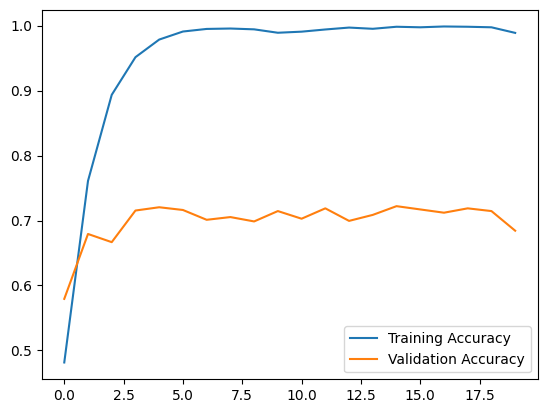

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


**Evaluating LSTM Model Performance**

*After training the LSTM model, this code evaluates its performance on the test set. The predictions are made using the model, and the accuracy is computed by comparing the predicted labels with the true labels. A classification report is also generated, providing detailed metrics such as precision, recall, and F1-score for each class, helping to assess the model's effectiveness in sentiment classification.*


In [ ]:
# Find the best validation accuracy and the corresponding epoch
best_epoch = max(range(len(history.history['val_accuracy'])), key=lambda i: history.history['val_accuracy'][i])
best_val_accuracy = history.history['val_accuracy'][best_epoch]

# Print the best validation accuracy and the epoch
print(f"Best Validation Accuracy: {best_val_accuracy:.4f} at epoch {best_epoch + 1}")


Best Validation Accuracy: 0.7221 at epoch 15


# Comparison for Naye Bayes and LSTM Model

**Comparing Model Accuracies**

*This code creates a bar chart to compare the accuracy of the Naive Bayes and LSTM models. The chart visualizes the performance of both models, with their respective accuracies represented on the y-axis. This comparison helps in evaluating which model performs better for the sentiment classification task based on their accuracy scores.*


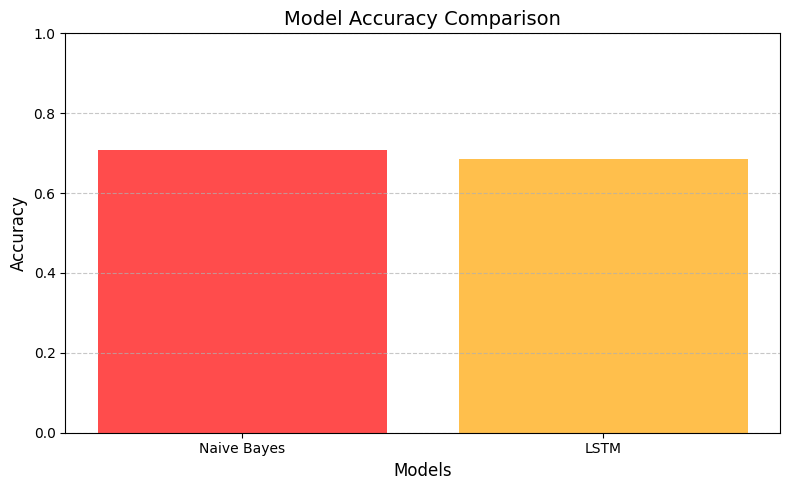

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Naive Bayes', 'LSTM']
accuracies = [nb_accuracy, lstm_accuracy]

# Bar chart
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['red', 'orange'], alpha=0.7)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Accuracy Comparison', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()


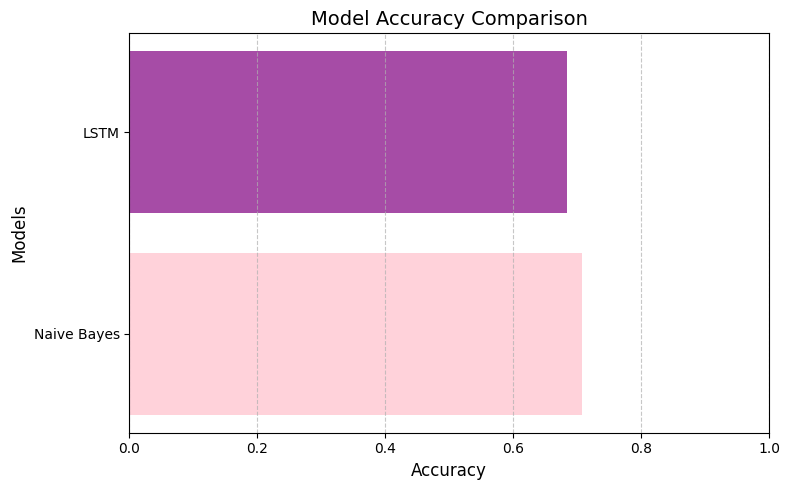

In [ ]:
plt.figure(figsize=(8, 5))
plt.barh(models, accuracies, color=['pink', 'purple'], alpha=0.7)
plt.ylabel('Models', fontsize=12)
plt.xlabel('Accuracy', fontsize=12)
plt.title('Model Accuracy Comparison', fontsize=14)
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# SVM - Support Vector Machine

**Label Encoding and TF-IDF Vectorization**

In this section, I have encoded the sentiment labels into numeric values using `LabelEncoder`. The dataset is then split into training and testing sets (80-20 split). For feature extraction, I have applied `TfidfVectorizer` to transform the text descriptions into numerical features. The vectorizer is set to consider unigrams and bigrams, while removing common English stopwords. These steps prepare the data for further model training and evaluation.


In [ ]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(df['description'], df['label'], test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

**SVM Hyperparameter Tuning with GridSearchCV**

*In this code, a parameter grid is defined for tuning the hyperparameters of an SVM (Support Vector Machine) model using `GridSearchCV`. The parameters include values for `C`, `kernel`, and `gamma`. The grid search performs cross-validation (with `cv=5`) and evaluates the model using accuracy as the scoring metric. After fitting the model to the training data (`X_train_tfidf` and `y_train`), the best hyperparameters are printed based on the highest accuracy achieved.*


In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


**Evaluating SVM Model Performance**

*In this code, the best estimator obtained from the grid search (`grid_search.best_estimator_`) is used to make predictions on the test data (`X_test_tfidf`). The accuracy of the model is then calculated using `accuracy_score` and printed. Additionally, a classification report is generated, providing detailed metrics such as precision, recall, and F1-score for each class, based on the true labels (`y_test`) and predicted labels (`y_pred`).*


In [ ]:
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Test Accuracy: 0.6023
Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.10      0.19       135
     neutral       0.56      0.83      0.67       395
    positive       0.66      0.54      0.59       350

    accuracy                           0.60       880
   macro avg       0.74      0.49      0.48       880
weighted avg       0.67      0.60      0.57       880



**Confusion Matrix Visualization**

*This code generates a confusion matrix to evaluate the performance of the SVM model on the test data. The matrix is visualized using a heatmap with annotations for each cell, displaying the number of true positives, false positives, true negatives, and false negatives.*

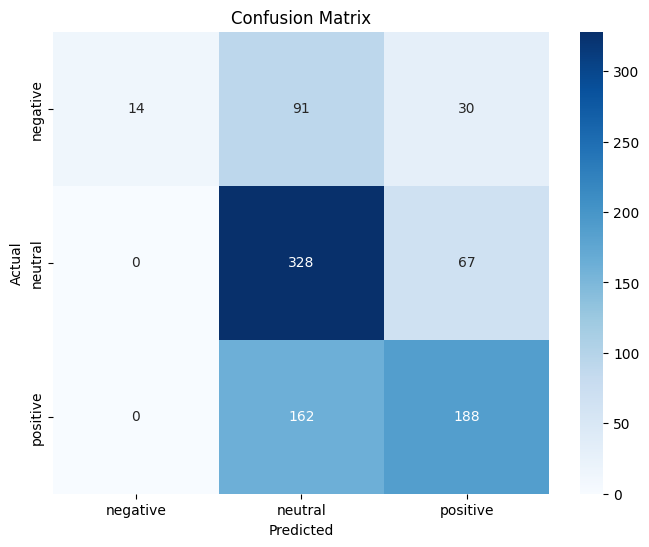

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Logistic Regression

**Feature Extraction with TF-IDF and Data Splitting**

*In this code, features are extracted from the text data using the `TfidfVectorizer`, which converts the cleaned reviews into a matrix of TF-IDF features. The `max_features` parameter is set to 10,000, and n-grams of size 1 and 2 are considered. The target labels (`sentiment`) are converted into binary format using `pd.get_dummies`. The data is then split into training and testing sets (80% training, 20% testing) using `train_test_split`, with a random state of 42 to ensure reproducibility.*


In [ ]:
print("Extracting features using TF-IDF...")
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = tfidf.fit_transform(df_resampled['cleaned_review'])
y = df_resampled['sentiment']

y = pd.get_dummies(y).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Extracting features using TF-IDF...


**Training Logistic Regression Model with Class Weighting**

*In this code, a Logistic Regression model is trained with class balancing using `class_weight='balanced'`. The class weights are computed using `compute_class_weight` to address any class imbalance in the dataset, and a dictionary of class weights is created. The model is trained using the training data (`X_train`) and the target labels (`y_train`), where the labels are transformed using `argmax` to ensure they are in a format suitable for multi-class classification.*


In [ ]:
print("Training Logistic Regression model...")
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_resampled['sentiment']),
    y=df_resampled['sentiment']
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

log_reg = LogisticRegression(max_iter=500, class_weight='balanced', multi_class='ovr')
log_reg.fit(X_train, y_train.argmax(axis=1))

Training Logistic Regression model...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=500, multi_class='ovr')

**Evaluating Logistic Regression Model Performance**

*In this code, the trained Logistic Regression model is evaluated on the test data (`X_test`). The predicted labels (`y_pred`) are compared to the true labels (`y_test_argmax`) to calculate the accuracy using `accuracy_score`. A classification report is also generated, providing detailed performance metrics such as precision, recall, and F1-score for each class.*


In [ ]:
print("Evaluating Logistic Regression model...")
y_pred = log_reg.predict(X_test)
y_test_argmax = y_test.argmax(axis=1)
accuracy = accuracy_score(y_test_argmax, y_pred)
print(f"Logistic Regression Model Accuracy: {accuracy}")
print(classification_report(y_test_argmax, y_pred))

Evaluating Logistic Regression model...
Logistic Regression Model Accuracy: 0.7170445004198153
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       402
           1       0.67      0.62      0.65       394
           2       0.68      0.69      0.68       395

    accuracy                           0.72      1191
   macro avg       0.71      0.72      0.71      1191
weighted avg       0.71      0.72      0.71      1191



**Confusion Matrix Visualization for Logistic Regression**

*This code visualizes the confusion matrix for the Logistic Regression model's predictions on the test data. The matrix is displayed using a heatmap with annotations for each cell, showing the count of true positives, false positives, true negatives, and false negatives. The axes are labeled with class names ('negative', 'neutral', 'positive'), providing a clear view of how the model performs across different sentiment classes.*


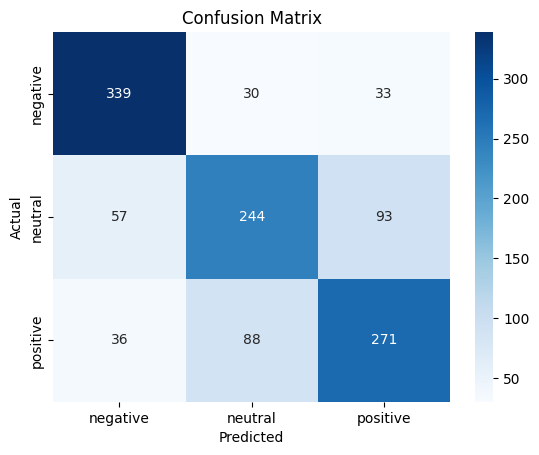

In [ ]:
cm = confusion_matrix(y_test_argmax, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**ROC Curve for Logistic Regression Model**

*In this code, the Receiver Operating Characteristic (ROC) curve is plotted for each class in the Logistic Regression model. The `roc_curve` function calculates the false positive rate (FPR) and true positive rate (TPR) for each class, and the area under the curve (AUC) is computed using `roc_auc_score`. The ROC curves for each class are plotted with different colors, and the AUC is displayed in the legend. The plot provides insights into the model's ability to distinguish between classes, with a higher AUC indicating better performance.*


In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], log_reg.predict_proba(X_test)[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], log_reg.predict_proba(X_test)[:, i])

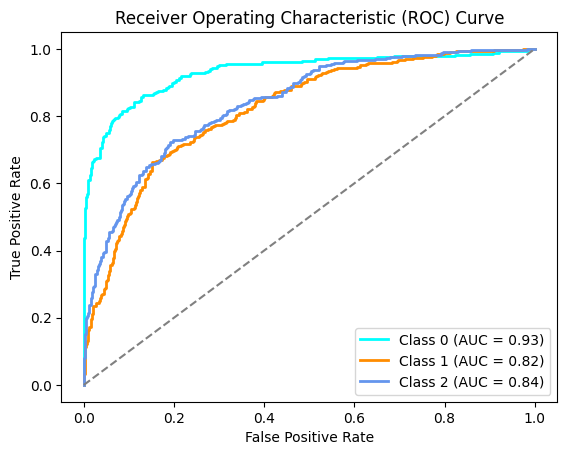

In [ ]:
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Ensemble Model

**Feature Scaling with StandardScaler**

*In this code, the features are scaled using `StandardScaler` to standardize the data before model training. The `with_mean=False` parameter is used to avoid centering the data, which is important for sparse matrices like TF-IDF. The scaler is fitted on the training data (`X_train`) and then applied to both the training and test data (`X_test`) to ensure consistent scaling during model evaluation.*


In [ ]:
print("Scaling features...")
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Scaling features...


**Training Ensemble Model with VotingClassifier**

*In this code, an ensemble model is created using `VotingClassifier`, which combines three classifiers: Logistic Regression, Random Forest, and Gradient Boosting. The classifiers are initialized with specific parameters, such as class balancing for the Logistic Regression and Random Forest. The ensemble model is trained using soft voting, where the predicted class label is based on the average predicted probabilities. The model is fitted on the training data (`X_train` and `y_train`).*


In [ ]:
print("Training Ensemble Model with VotingClassifier...")
log_reg = LogisticRegression(max_iter=500, class_weight='balanced', multi_class='ovr')
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

ensemble = VotingClassifier(estimators=[
    ('log_reg', log_reg),
    ('random_forest', rf),
    ('gradient_boosting', gb)
], voting='soft')

ensemble.fit(X_train, y_train.argmax(axis=1))

Training Ensemble Model with VotingClassifier...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


VotingClassifier(estimators=[('log_reg',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=500,
                                                 multi_class='ovr')),
                             ('random_forest',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('gradient_boosting',
                              GradientBoostingClassifier(random_state=42))],
                 voting='soft')

**Evaluating Ensemble Model Performance**

*In this code, the ensemble model's performance is evaluated on the test data (`X_test`). The predicted labels (`y_pred`) are compared with the true labels (`y_test_argmax`) to calculate the accuracy using `accuracy_score`. A classification report is also generated, providing detailed metrics such as precision, recall, and F1-score for each class. These metrics help assess the effectiveness of the ensemble model across the different sentiment categories.*


In [ ]:
print("Evaluating Ensemble Model...")
y_pred = ensemble.predict(X_test)
y_test_argmax = y_test.argmax(axis=1)
accuracy = accuracy_score(y_test_argmax, y_pred)
print(f"Ensemble Model Accuracy: {accuracy}")
print(classification_report(y_test_argmax, y_pred))

Evaluating Ensemble Model...
Ensemble Model Accuracy: 0.7523089840470193
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       402
           1       0.69      0.62      0.66       394
           2       0.70      0.68      0.69       395

    accuracy                           0.75      1191
   macro avg       0.75      0.75      0.75      1191
weighted avg       0.75      0.75      0.75      1191



**Training Ensemble Model with StackingClassifier**

*In this code, an ensemble model is trained using `StackingClassifier`, which combines three base classifiers: Logistic Regression, Random Forest, and Gradient Boosting. The predictions from these classifiers are used as input to a final Logistic Regression model, which makes the final decision. The stacking model is trained using 5-fold cross-validation (`cv=5`) to ensure robustness. The model is fitted on the training data (`X_train` and `y_train`).*


In [ ]:
print("Training Ensemble Model with StackingClassifier...")
log_reg = LogisticRegression(max_iter=500, class_weight='balanced', multi_class='ovr')
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

ensemble = StackingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('random_forest', rf),
        ('gradient_boosting', gb)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

ensemble.fit(X_train, y_train.argmax(axis=1))


Training Ensemble Model with StackingClassifier...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

StackingClassifier(cv=5,
                   estimators=[('log_reg',
                                LogisticRegression(class_weight='balanced',
                                                   max_iter=500,
                                                   multi_class='ovr')),
                               ('random_forest',
                                RandomForestClassifier(class_weight='balanced',
                                                       random_state=42)),
                               ('gradient_boosting',
                                GradientBoostingClassifier(random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000))

**Evaluating Ensemble Model Performance**

*In this code, the performance of the stacked ensemble model is evaluated on the test data (`X_test`). The predicted labels (`y_pred`) are compared with the true labels (`y_test_argmax`) to calculate the accuracy using `accuracy_score`. A classification report is generated, which includes metrics such as precision, recall, and F1-score for each class. These metrics provide a comprehensive assessment of the model's effectiveness across different sentiment categories.*


In [ ]:
print("Evaluating Ensemble Model...")
y_pred = ensemble.predict(X_test)
y_test_argmax = y_test.argmax(axis=1)
accuracy = accuracy_score(y_test_argmax, y_pred)
print(f"Ensemble Model Accuracy: {accuracy}")
print(classification_report(y_test_argmax, y_pred))

Evaluating Ensemble Model...
Ensemble Model Accuracy: 0.7825356842989085
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       402
           1       0.69      0.72      0.70       394
           2       0.70      0.68      0.69       395

    accuracy                           0.78      1191
   macro avg       0.78      0.78      0.78      1191
weighted avg       0.78      0.78      0.78      1191



**Confusion Matrix Visualization for Ensemble Model**

*This code generates and visualizes the confusion matrix for the stacked ensemble model's predictions on the test data. The matrix is displayed using a heatmap, where the cells are annotated with the number of true positives, false positives, true negatives, and false negatives. The axes are labeled with the class names ('negative', 'neutral', 'positive') to provide a clear view of how well the model distinguishes between different sentiment categories.*


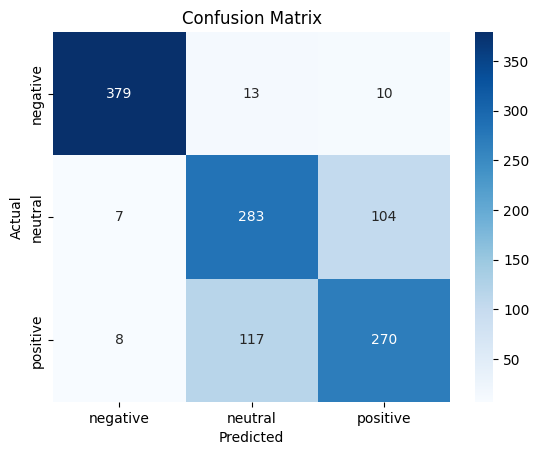

In [ ]:
cm = confusion_matrix(y_test_argmax, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**ROC Curve for Stacked Ensemble Model**

*This code plots the Receiver Operating Characteristic (ROC) curve for the stacked ensemble model, evaluating its performance across the three sentiment classes. The `roc_curve` function is used to calculate the false positive rate (FPR) and true positive rate (TPR) for each class, and the area under the curve (AUC) is computed using `roc_auc_score`. Each class's ROC curve is plotted with distinct colors, and the AUC for each class is displayed in the legend. The plot helps assess the model's ability to discriminate between classes, with higher AUC values indicating better performance.*


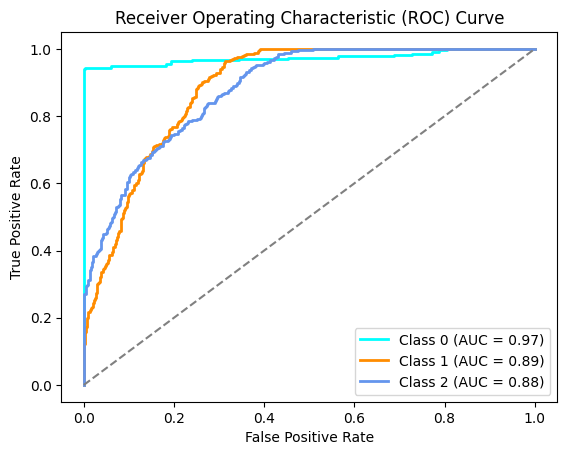

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], ensemble.predict_proba(X_test)[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], ensemble.predict_proba(X_test)[:, i])

plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# **Conclusion**

*In this project, various models including Naye Bayes, LSTM, SVM, Logistic Regression, and ensemble methods like Voting and Stacking classifiers were trained and evaluated for sentiment analysis. The performance of each model was assessed using accuracy, classification reports, confusion matrices, and ROC curves. The ensemble models, in particular, demonstrated promising results, highlighting the potential of combining multiple classifiers to improve overall performance in sentiment classification tasks.*
